In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from tqdm.autonotebook import tqdm

import numpy as np
import tensorflow as tf
from avgn.utils.paths import DATA_DIR

from avgn.datasets.nsynth import HParams, NSynthDataset
from avgn.networks.ae import AE

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### define hparams

In [3]:
hparams = HParams(  
    batch_size = 128,
    win_length = 512,
    n_fft = 1024,
    hop_length= 400,
    ref_level_db = 20,
    min_level_db = -100,
    power = 1, # for spectral inversion
    griffin_lim_iters = 50,
    spectrogram = True,
    #pad=True,
    mel = True,
    mfcc = False,
    mel_matrix_dict = {
        'num_mel_bins': 32,
        'num_spectrogram_bins' : 513,
        'sample_rate' : 16000,
        'lower_edge_hertz':125.0,
        'upper_edge_hertz':3800.0,
    }
)

### Get dataset

In [4]:
training_tfrecords = list((DATA_DIR / "tensorflow_datasets"/"nsynth").glob('**/*train.tfrecord*'))

In [5]:
dset = NSynthDataset([str(i) for i in training_tfrecords], hparams, num_parallel_calls = 24)

In [6]:
exs = iter(dset.dataset_batch)
ex = next(exs)
spec_ex = ex['spectrogram'].numpy()[0]

In [7]:
np.shape(spec_ex)

(160, 32)

In [8]:
example_data = tf.expand_dims(next(iter(dset.dataset_batch))['spectrogram'], axis=3)

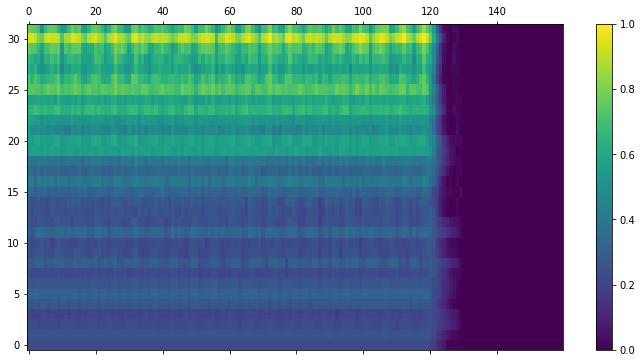

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
cset1 = ax.matshow(np.squeeze(example_data.numpy()[0]).T, aspect='auto', origin='lower')
fig.colorbar(cset1, ax=ax)

In [10]:
list(example_data.shape)

[128, 160, 32, 1]

### Make network

In [11]:
from tensorflow.keras.layers import (
    RepeatVector,
    Dense,
    TimeDistributed,
    Conv1D,
    Conv2D,
    Reshape,
    Bidirectional,
)  # , LSTM
from tensorflow.python.keras.layers.recurrent import UnifiedLSTM as LSTM
from tensorflow.python.keras.layers.recurrent import UnifiedGRU as GRU
#from tensorflow.keras.layers import CuDNNLSTM as LSTM

In [12]:
seq_len = 10 # the number of items in the sequence, which is determined by convolutional downsampling
spec_chans_last = 4

In [13]:
enc = [
        tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=6,
            strides=(4, 2),
            activation="relu",
            padding="same",
        ),
        tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=6,
            strides=(2, 2),
            activation="relu",
            padding="same",
        ),
        tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=6,
            strides=(2, 2),
            activation="relu",
            padding="same",
        ),
        Reshape(target_shape=(seq_len, spec_chans_last*64)),
        Bidirectional(LSTM(units=512, activation="relu")),
        #Dense(units=512)
    ]

W0507 11:10:22.102108 140529621030656 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fcf001c92b0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0507 11:10:22.108993 140529621030656 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fcf001c9940>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [14]:
dec = [
        #Dense(units=512),
        RepeatVector(seq_len),
        Bidirectional(LSTM(units=512, activation="relu", return_sequences=True)),
        TimeDistributed(Dense(spec_chans_last * 64)), # features times the number of filters
        Reshape(target_shape=(seq_len, spec_chans_last, 64)),
        tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=6,
            strides=(4, 2),
            padding="SAME",
            activation="relu",
        ),
        tf.keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=6,
            strides=(2, 2),
            padding="SAME",
            activation="relu",
        ),
        tf.keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=6,
            strides=(2, 2),
            padding="SAME",
            activation="relu",
        ),
        tf.keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=6,
            strides=(1, 1),
            padding="SAME",
            activation="tanh",
        ),
        Reshape(target_shape=(160, 32, 1)),
    ]

W0507 11:10:22.177899 140529621030656 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fcf0015e278>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0507 11:10:22.181024 140529621030656 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fcf0015e908>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
model = AE(
    enc = enc,
    dec = dec,
    optimizer = optimizer
)

In [ ]:
ex_z = model.encode(example_data)
print(ex_z.shape)

(128, 1024)


In [ ]:
np.max((ex_z.numpy()))

0.054823786

In [ ]:
ex_x = model.decode(ex_z)
print(ex_x.shape)

(128, 160, 32, 1)


In [ ]:
examp = next(iter(dset.dataset_batch))['spectrogram']

In [ ]:
example_loss = []

0.15637034


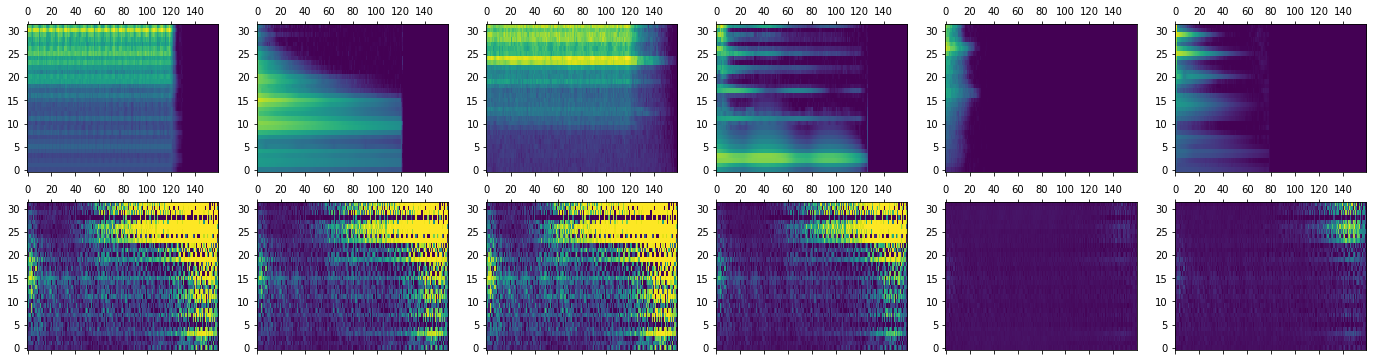

0.66124487


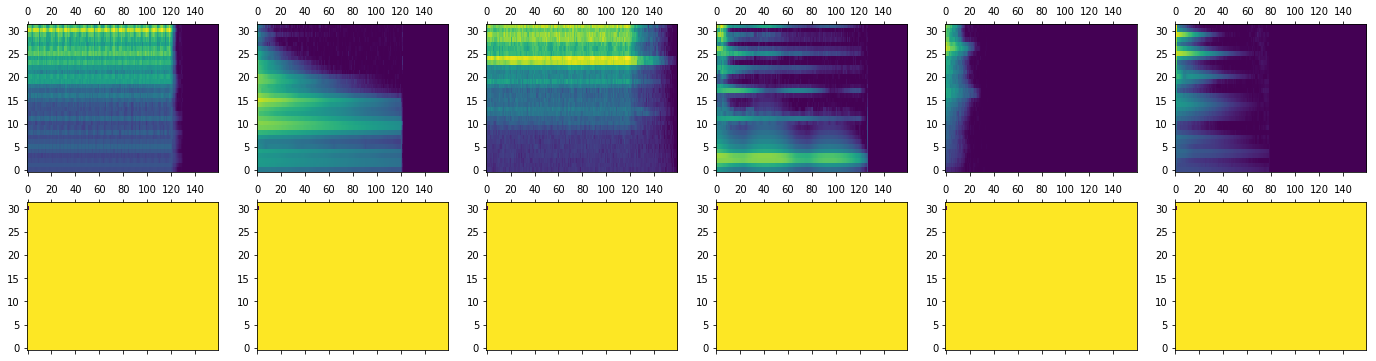

0.66124487


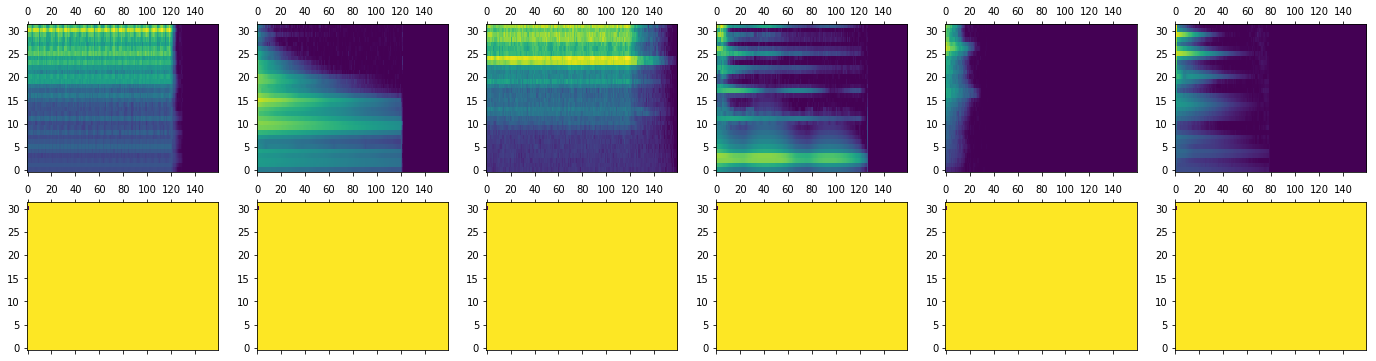

0.66124487


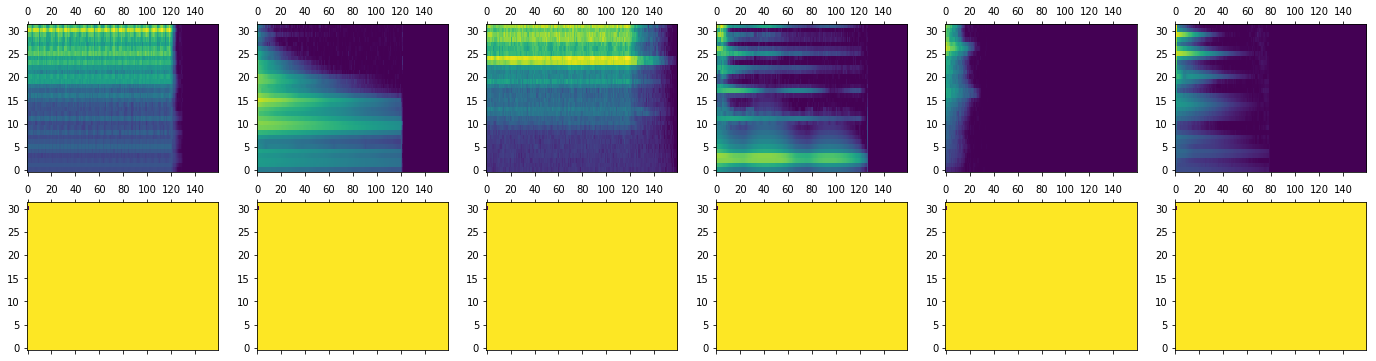

In [ ]:
for epoch in range(1000): 
    txi = 0
    for train_x in tqdm(dset.dataset_batch):
        gradients = model.compute_gradients(tf.expand_dims(train_x['spectrogram'], axis=3))
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 
        txi +=1
        if (txi % 100 == 0): 
            if (txi % 1000 == 0) & (epoch !=0):
                display.clear_output(wait=False)
                plt.loglog(example_loss)
                plt.show()
            example_loss.append(model.compute_loss(example_data).numpy())
            print(example_loss[-1])
            recon = model.decode(model.encode(example_data))
            nex = 6
            fig, axs = plt.subplots(nrows =2,ncols = nex, figsize=(nex*4,3*2))
            for nix in range(nex):
                axs[0, nix].matshow(np.squeeze(example_data.numpy()[nix]).T, vmin=0, vmax=1, aspect='auto', origin='lower')
                axs[1, nix].matshow(np.squeeze(recon.numpy()[nix]).T, vmin=0, vmax=1, aspect='auto', origin='lower')
            plt.show()

    

In [ ]:
plt.loglog(example_loss)

In [ ]:
np.mean(example_loss[-10:])
# 0.0007693957


In [ ]:
plt.plot(np.mean(example_data.numpy()[0], axis=0))
plt.plot(np.mean(recon.numpy()[0], axis=0))

In [ ]:
plt.plot(np.mean(example_data.numpy()[0], axis=1))
plt.plot(np.mean(recon.numpy()[0], axis=1))